This project reference on paper https://machinelearningcoban.com/2017/05/31/matrixfactorization/ by author Vu Huu Tiep


In [9]:
cd /content/drive/MyDrive/Book_recommender

/content/drive/MyDrive/Book_recommender


In [2]:
import pandas as pd 
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from scipy import sparse 
import json
import time
from tabulate import tabulate

In [24]:
ratings = pd.read_csv('./data/train1.csv')
Y_data = ratings.values
ratings2 = pd.read_csv('./data/test1.csv')
Y_data_test = ratings2.values

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [17]:

class MF(object):
    """docstring for CF"""
    def __init__(self, Y_data, Y_data_test, K, lam = 0.1, Xinit = None, Winit = None, 
                 learning_rate = 0.5, max_iter = 1000, print_every = 100, user_based = 1):
        self.Y_raw = Y_data.copy()
        self.Y_data_test = Y_data_test
        # self.Y_data = Y_data.copy()
        self.K = K
        self.lam = lam
        self.learning_rate = learning_rate
        self.max_iter = max_iter
        self.print_every = print_every
        self.user_based = user_based
        #List of userid
        with open('./data/userid.json', 'r') as f:
          self.userid = json.load(f)
        #List of bookid
        with open('./data/bookid.json','r') as f2:
          self.bookid = json.load(f2)
        #List of mean rate each users
        with open('./data/mean_ratings.json','r') as f3:
          self.muu = json.load(f3)
        #List of book titles
        with open('./data/book_title.json','r') as f4:
          self.book_title = json.load(f4)

        #Len of users   
        self.n_users = len(self.userid)
        #Len of items
        self.n_items = len(self.bookid)
        
        self.Y_data = pd.read_csv('./data/normalize_matrix_MF.csv').values 

        ##Randomly W and S for training
        # if Xinit is None: 
        #     self.X = np.random.randn(self.n_items, K)
        # else:
        #     self.X = Xinit 
        
        # if Winit is None: 
        #     self.W = np.random.randn(K, self.n_users)
        #     # print("W: ",self.W)
        # else: 
        #     self.W = Winit
        
        # # item biases
        # self.b = np.random.randn(self.n_items)
        # self.d = np.random.randn(self.n_users)

        ##Load the saved weights after training
        data = np.load('./data/MF_final_parameter_X_W_b_d_version2.npz')
        self.X = data['X']
        self.W = data['W']
        self.b = data['b']
        self.d = data['d']


        self.n_ratings = Y_data.shape[0]
        self.mu = np.mean(Y_data[:, 2])
        # self.mu = 0

        
 

    def normalize_Y(self):
        if self.user_based:
            user_col = 1
            item_col = 0
            n_objects = self.userid
        else:
            user_col = 0
            item_col = 1 
            n_objects = self.bookid

        #list of user
        users = self.Y_data[:, user_col] 
        #Initialize the list of mean rate
        self.muu = {}
        print(self.n_users)
        i=0
        for key in n_objects.keys():
            i+=1
            print(i)
            # row indices of rating done by user n
            # since indices need to be integers, we need to convert
            ids = np.where(users == key)[0].astype(np.int32)
            # indices of all ratings associated with user n
            item_ids = self.Y_data[ids, item_col] 
            # and the corresponding ratings 
            ratings = self.Y_data[ids, 2]
            # take mean
            m = np.mean(ratings) 
            if np.isnan(m):
                m = 0 # to avoid empty array and nan value

            self.muu[key] = m
            # normalize
            self.Y_data[ids, 2] = ratings - m

        #Save mean 
        file_path = "./data/mean_ratings_MF.json"
        with open(file_path, 'w') as json_file:
            json.dump(self.muu, json_file)

        #Save normalize data
        file_path = "./data/normalize_matrix_MF.csv"
        with open(file_path, mode='w', newline='') as file:
            writer = csv.writer(file)
            writer.writerow(["user", "book", "rating"])
            i=0
            for row in self.Y_data:
                i+=1
                print(i)
                writer.writerow(row)
            
            
    def loss(self):
        L = 0 
        for i in range(self.n_ratings):
            # user, item, rating
            n, m, rate = self.userid[self.Y_data[i, 1]]-1, self.bookid[str(self.Y_data[i, 0])]-1, self.Y_data[i, 2]
            L += 0.5*(self.X[m, :].dot(self.W[:, n]) + self.b[m] + self.d[n] + self.mu - rate)**2
            
        # regularization, don't ever forget this 
        L /= self.n_ratings
        L += 0.5*self.lam*(np.linalg.norm(self.X, 'fro') + np.linalg.norm(self.W, 'fro') + np.linalg.norm(self.b) + np.linalg.norm(self.d))
        return L 

    
    def get_items_rated_by_user(self, user_id):
        """
        get all items which are rated by user n, and the corresponding ratings
        """
        ids = np.where(self.Y_data[:,1] == user_id)[0] 
        item_ids = self.Y_data[ids, 0] 
        ratings = self.Y_data[ids, 2]
        return (item_ids, ratings)
        
        
    def get_users_who_rate_item(self, item_id):
        """
        get all users who rated item m and get the corresponding ratings
        """
        ids = np.where(self.Y_data[:,0] == int(item_id))[0] 
        user_ids = self.Y_data[ids, 1]
        ratings = self.Y_data[ids, 2]
        return (user_ids, ratings)
        
    def updateX(self):
        for book in self.bookid.keys():
            user_ids, ratings = self.get_users_who_rate_item(book)
            Wm = self.W[:, [self.userid[i]-1 for i in user_ids]]
            dm = self.d[[self.userid[i]-1 for i in user_ids]]
            xm = self.X[self.bookid[str(book)]-1, :]
            
            error = xm.dot(Wm) + self.b[self.bookid[str(book)]-1] + dm + self.mu - ratings 
            
            grad_xm = error.dot(Wm.T)/self.n_ratings + self.lam*xm
            grad_bm = np.sum(error)/self.n_ratings + self.lam*self.b[self.bookid[str(book)]-1]
            self.X[self.bookid[str(book)]-1, :] -= self.learning_rate*grad_xm.reshape((self.K,)).astype('float64')
            self.b[self.bookid[str(book)]-1]    -= self.learning_rate*grad_bm
            # print("X: ",self.X[self.bookid[str(book)], :],"bias: ", self.b[self.bookid[str(book)]])
        print("end of X")

    
    def updateW(self):
        for user in self.userid.keys():
            item_ids, ratings = self.get_items_rated_by_user(user)
            Xn = self.X[[self.bookid[str(i)]-1 for i in item_ids], :]
            bn = self.b[[self.bookid[str(i)]-1 for i in item_ids]]
            wn = self.W[:, self.userid[user]-1]
            
            error = Xn.dot(wn) + bn + self.mu + self.d[self.userid[user]-1] - ratings
            grad_wn = Xn.T.dot(error)/self.n_ratings + self.lam*wn
            grad_dn = np.sum(error)/self.n_ratings + self.lam*self.d[self.userid[user]-1]
            self.W[:, self.userid[user]-1] -= self.learning_rate*grad_wn.reshape((self.K,)).astype('float64')
            self.d[self.userid[user]-1]    -= self.learning_rate*grad_dn
            # print("W: ",self.W[:, self.userid[user]],"bias: ",self.d[self.userid[user]])
        print("end of W")
    
    def fit(self):
        # self.normalize_Y()
        loss = []
        train_error = []
        test_error = []
        data = np.load("./data/Sai_so2.npz")

        # Extract the list from the loaded data
        train_error = data['RMSE_train']
        test_error = data['RMSE_test']
        loss = data['loss']
        for it in range(self.max_iter):
            start_time = time.time()
            print("iteration: ",it+1)
            self.updateX()
            self.updateW()
            
            end_time = time.time()
            execution_time = end_time - start_time
            print("TIME PER ITER: ", execution_time)
            if (it + 1) % self.print_every == 0:
                rmse_train = self.evaluate_RMSE(self.Y_raw)
                rmse_test  = self.evaluate_RMSE(self.Y_data_test)
                np.append(train_error,rmse_train)
                np.append(test_error,rmse_test)
                a=self.loss()
                np.append(loss, a)
                print('iter =', it + 1, ', loss =', a, ', RMSE train =', rmse_train, 'RMSE test = ', rmse_test)

                np.savez('./data/MF_final_parameter_X_W_b_d_version3.npz', X=self.X, W=self.W, b=self.b, d=self.d)
                np.savez('./data/Sai_so2.npz', RMSE_train=train_error, RMSE_test=test_error, loss=loss)
        
    
    
    def pred(self, u, i):
        """ 
        predict the rating of user u for item i 
        if you need the un
        """
        
        if self.user_based == 1:
            normalize_back = self.muu[u]
        else:
            normalize_back = self.muu[i]

        u = self.userid[u]-1
        i = self.bookid[str(i)]-1
        
        pred = self.X[i, :].dot(self.W[:, u]) + self.b[i] + self.d[u] + normalize_back
#         if pred < 0:
#             return 0 
#         if pred > 5: 
#             return 5 
#         return pred 
        return max(0, min(5, pred))
        
    
    def pred_for_user(self, user_id):
        ids = np.where(self.Y_raw[:, 1] == user_id)[0]
        items_rated_by_u = self.Y_raw[ids, 0].tolist()              

        if self.user_based == 1:
            normalize_back = self.muu[user_id]
        else:
            normalize_back = self.muu[i]

        user_id = self.userid[user_id]-1
        y_pred = self.X.dot(self.W[:, user_id]) + self.b + self.d[user_id] + normalize_back
        book_order_list = [self.bookid[str(i)] for i in items_rated_by_u ]
        # print(book_order_list)
        itss = [i-1 for i in book_order_list]

        # print("y_pred: ",y_pred)
        predicted_ratings= {}
        index = 0
        for i in self.bookid.keys():
            if int(i) not in items_rated_by_u:
                index+=1
                # i là tên sách book order là thứ tự của sách = thứ tự của sách tương ứng trong y_pred
                book_order = self.bookid[i] - 1
                if i not in self.book_title.keys():
                  continue
                book_title = self.book_title[i]
                predicted_ratings[book_title] = y_pred[book_order]

        predicted_ratings = dict(sorted(predicted_ratings.items(), key=lambda item: item[1]))
        data = [[title, rating] for title, rating in predicted_ratings.items()]
        #Only pick top 10 highest score books
        data = data[-10:]
        table = tabulate(data[::-1], headers=["Title", "Rating"], tablefmt="grid")
        print("Top recomended books for user: ", target_user)
        print(table)
        return predicted_ratings
    
    def evaluate_RMSE(self, rate_test):
        n_tests = rate_test.shape[0]
        SE = 0 # squared error
        k=0
        for n in range(n_tests):
          if rate_test[n, 1] not in rs.userid.keys():
            continue
          if str(rate_test[n, 0]) not in rs.bookid.keys():
            continue
          k+=1
          # print(k)
          pred = self.pred(rate_test[n, 1], rate_test[n, 0])
#             print pred, rate_test[n, 2]
          SE += (pred - rate_test[n, 2])**2 
        print(k)
        RMSE = np.sqrt(SE/n_tests)
        return RMSE
        
# loss = 7.474733146084495 , RMSE train = 1.057749948147554

In [18]:
rs = MF(Y_data, Y_data_test, K = 3, max_iter = 35, print_every = 5, lam = 0.)

start_time = time.time()
target_user = 'f14eb7b97b91a036f392e8374ac1ba89'
a=rs.pred_for_user(target_user)


end_time = time.time()
execution_time = end_time - start_time
print("Execution time:", execution_time, "seconds")
# rs.normalize_Y()
# rs.fit()
# rs.pred('05094dcfaac099025c7ddb4cdd2be942', 16729)

# print(rs.evaluate_RMSE(Y_data_test))
# print(rs.loss())
#RMSE= 1.1799055787033665

Top recomended books for user:  f14eb7b97b91a036f392e8374ac1ba89
+------------------------------------------------+----------+
| Title                                          |   Rating |
+================================================+==========+
| Julia's Last Hope (Women of the West, #2)      |  2.94876 |
+------------------------------------------------+----------+
| Thirst                                         |  2.94735 |
+------------------------------------------------+----------+
| Yoga: The Science of the Soul                  |  2.94726 |
+------------------------------------------------+----------+
| The Light of Day                               |  2.94617 |
+------------------------------------------------+----------+
| Sideways                                       |  2.94598 |
+------------------------------------------------+----------+
| The Far Side Gallery                           |  2.94388 |
+------------------------------------------------+----------+
| Tra

[1.60530255 1.39645845 1.26188279 1.17909304 1.12922811 1.0996824
 1.08232448 1.07211691 1.06611493 1.06258936 1.0605244  1.05931836
 1.05861855 1.05821665 1.05798886 1.05786224 1.05779405 1.0577591
 1.05774273 1.05773643]
[1.64068823 1.46251666 1.34872721 1.27981999 1.23898254 1.21485111
 1.20070444 1.19231322 1.1873388  1.18438745 1.18263321 1.18158021
 1.18094745 1.18056706 1.18033607 1.18019249 1.18010169 1.18004333
 1.18000513 1.17997929]


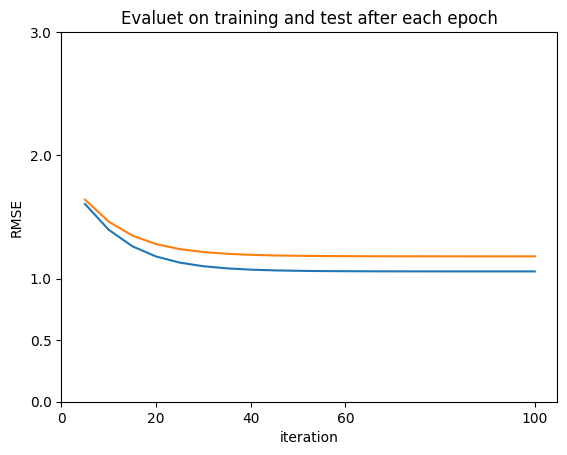

In [22]:
import matplotlib.pyplot as plt
import numpy as np

# Load the .npz file
data = np.load("./data/Sai_so.npz")

# Extract the list from the loaded data
RMSE_train = data['RMSE_train']
RMSE_test = data['RMSE_test']
print(RMSE_train)
print(RMSE_test)
loss = data['loss']
iter = [5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100]
plt.plot(iter, RMSE_train)
plt.plot(iter, RMSE_test)
plt.xlabel('iteration')
plt.ylabel('RMSE')
plt.title('Evaluet on training and test after each epoch')
plt.yticks([0, 0.5, 1.0, 2.0, 3.0])  # Chỉ hiển thị chỉ mục 20, 30, 40 trên trục x
plt.xticks([0, 20, 40 , 60, 100])
plt.show()

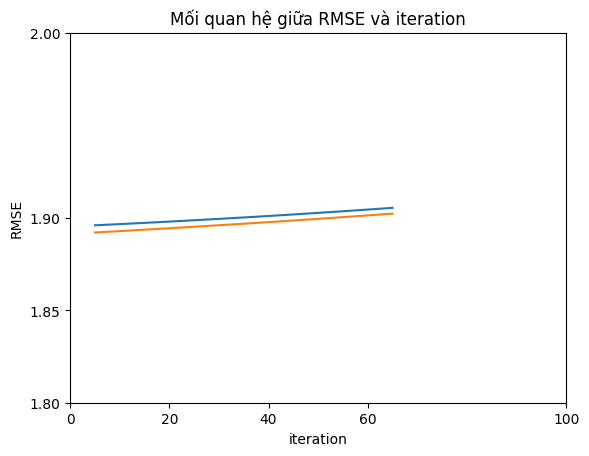

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Load the .npz file

# Extract the list from the loaded data
RMSE_train = [1.89600728, 1.89665337, 1.89732278, 1.89801687, 1.89873633, 1.89948176, 1.9002533,  1.90105408, 1.90188174, 1.90273536, 1.90361426, 1.90452209, 1.90545632]
RMSE_test = [1.89211838, 1.89285984, 1.89362807, 1.89441505, 1.89521912, 1.8960398, 1.8968718,  1.89772426, 1.89860101, 1.89950167, 1.90042604, 1.90137119, 1.90233276]

iter = [5,10,15,20,25,30,35,40,45,50,55,60,65]
plt.plot(iter, RMSE_train)
plt.plot(iter, RMSE_test)
plt.xlabel('iteration')
plt.ylabel('RMSE')
plt.title('Mối quan hệ giữa RMSE và iteration')
plt.yticks([1.80, 1.85, 1.90, 2.0])  # Chỉ hiển thị chỉ mục 20, 30, 40 trên trục x
plt.xticks([0, 20, 40 , 60, 100])
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Load the .npz file
data = np.load("./data/Sai_so2.npz")

# Extract the list from the loaded data
RMSE_train = data['RMSE_train']
RMSE_test = data['RMSE_test']
loss = data['loss']
print(RMSE_train)
print(RMSE_test)

# [1.89600728 1.89665337 1.89732278 1.89801687 1.89873633 1.89948176
#  1.9002533  1.90105408 1.90188174 1.90273536 1.90361426 1.90452209
#  1.90545632]
# [1.89211838 1.89285984 1.89362807 1.89441505 1.89521912 1.8960398
#  1.8968718  1.89772426 1.89860101 1.89950167 1.90042604 1.90137119
#  1.90233276]

[1.89600728 1.89665337 1.89732278 1.89801687 1.89873633 1.89948176
 1.9002533  1.90105408 1.90188174 1.90273536 1.90361426 1.90452209
 1.90545632]
[1.89211838 1.89285984 1.89362807 1.89441505 1.89521912 1.8960398
 1.8968718  1.89772426 1.89860101 1.89950167 1.90042604 1.90137119
 1.90233276]
